In [3]:
# Necessary for the local package to work correctly
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import itertools
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D

from rdkit import Chem
from rdkit.Chem import AllChem, Draw, rdchem, rdmolfiles, rdmolops, rdPartialCharges

# Pandas options
# 1. Max column width (-1 wraps text)
# 2. Max num of rows to display
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 25)

# Seaborn options
# 1. Axes style
# 2. Presentation style (text size)
sns.set_style('ticks')
sns.set_context('talk')

# Matplotlib options
# 1. LaTeX style font (Computer Modern Roman)
# 2. Use TeX for math symbols/graphics (glyps)
# 3. Inline plot
# 4. Enable retina (high resolution) plots
plt.rc('font',**{'family':'serif', 'serif': 'cmr10'})
plt.rc('text', **{'usetex': True})
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Misc options
# 1. Print pkg versions
# 2. Reload external modules automatically
%load_ext watermark
%load_ext autoreload
%autoreload 2

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
%watermark -u -n -t -z -v -m -g

last updated: Wed Nov 06 2019 18:22:56 EST 

CPython 3.7.4
IPython 7.8.0

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 17.7.0
machine    : x86_64
processor  : i386
CPU cores  : 2
interpreter: 64bit
Git hash   : 2a30076d2fcb9f55ebcb6dfdf5ec16609b09821e


In [5]:
%watermark --iversions

matplotlib 3.1.1
json       2.0.9
rdkit      2019.03.4
pandas     0.25.1
numpy      1.17.2
seaborn    0.9.0



In [6]:
def one_hot(x, allowable_set):
    # Use last index of set if x is not in set
    if x not in allowable_set:
        x = allowable_set[:-1]
    return list(map(lambda s: int(x == s), allowable_set))


def construct_mol_features(mol, out_size=-1):
    # Caluclate charges and chirality of atoms within molecule
    rdPartialCharges.ComputeGasteigerCharges(mol) # stored under _GasteigerCharge
    rdmolops.AssignStereochemistry(mol) # stored under _CIPCode, see doc for more info

    # Retrieve atom index locations of matches
    HYDROGEN_DONOR = rdmolfiles.MolFromSmarts("[$([N;!H0;v3,v4&+1]),$([O,S;H1;+0]),n&H1&+0]")
    HYROGEN_ACCEPTOR = rdmolfiles.MolFromSmarts("[$([O,S;H1;v2;!$(*-*=[O,N,P,S])]),$([O,S;H0;" + 
                                                "v2]),$([O,S;-]),$([N;v3;!$(N-*=[O,N,P,S])])," + 
                                                "n&H0&+0,$([o,s;+0;!$([o,s]:n);!$([o,s]:c:n)])]")
    ACIDIC = rdmolfiles.MolFromSmarts("[$([C,S](=[O,S,P])-[O;H1,-1])]")
    BASIC = rdmolfiles.MolFromSmarts("[#7;+,$([N;H2&+0][$([C,a]);!$([C,a](=O))]),$([N;H1&+0]" + 
                                     "([$([C,a]);!$([C,a](=O))])[$([C,a]);!$([C,a](=O))]),$" + 
                                     "([N;H0&+0]([C;!$(C(=O))])([C;!$(C(=O))])[C;!$(C(=O))])]")
    hydrogen_donor_match = sum(mol.GetSubstructMatches(HYDROGEN_DONOR), ())
    hydrogen_acceptor_match = sum(mol.GetSubstructMatches(HYROGEN_ACCEPTOR), ())
    acidic_match = sum(mol.GetSubstructMatches(ACIDIC), ())
    basic_match = sum(mol.GetSubstructMatches(BASIC), ())

    # Get ring info
    ring = mol.GetRingInfo()

    mol_feats = []
    n_atoms = mol.GetNumAtoms()
    for atom_idx in range(n_atoms):
        atom = mol.GetAtomWithIdx(atom_idx)

        atom_feats = []
        atom_feats += one_hot(atom.GetSymbol(), ['C', 'O', 'N', 'S', 'Cl', 'F', 'Br', 'P', 
                                                 'I', 'Si', 'B', 'Na', 'Sn', 'Se', 'other'])
        atom_feats += one_hot(atom.GetDegree(), [1,2,3,4,5,6])
        atom_feats += one_hot(atom.GetHybridization(), [rdchem.HybridizationType.SP,
                                                        rdchem.HybridizationType.SP2,
                                                        rdchem.HybridizationType.SP3,
                                                        rdchem.HybridizationType.SP3D,
                                                        rdchem.HybridizationType.SP3D2])
        atom_feats += one_hot(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5, 6])
        atom_feats += one_hot(atom.GetFormalCharge(), [-3, -2, -1, 0, 1, 2, 3])
        atom_feats += [atom.GetProp("_GasteigerCharge")]
        atom_feats += [atom.GetIsAromatic()]

        atom_feats += [ring.IsAtomInRingOfSize(atom_idx, 3),
                       ring.IsAtomInRingOfSize(atom_idx, 4),
                       ring.IsAtomInRingOfSize(atom_idx, 5),
                       ring.IsAtomInRingOfSize(atom_idx, 6),
                       ring.IsAtomInRingOfSize(atom_idx, 7),
                       ring.IsAtomInRingOfSize(atom_idx, 8)]
        atom_feats += one_hot(atom.GetTotalNumHs(), [0, 1, 2, 3, 4])

        # Chirality
        try:
            atom_feats += one_hot(atom.GetProp('_CIPCode'), ["R", "S"]) + [atom.HasProp("_ChiralityPossible")]
        except:
            atom_feats += [False, False] + [atom.HasProp("_ChiralityPossible")]
        # Hydrogen bonding
        atom_feats += [atom_idx in hydrogen_donor_match]
        atom_feats += [atom_idx in hydrogen_acceptor_match]
        # Is Acidic/Basic
        atom_feats += [atom_idx in acidic_match]
        atom_feats += [atom_idx in basic_match]

        mol_feats.append(atom_feats)

    if out_size < 0:
        return np.array(mol_feats, dtype=np.float)
    elif out_size >= n_atoms:
        # 'empty' padding for `mol_feats`. Useful to generate feature matrix of same size for all mols
        # NOTE: len(mol_feats[0]) is the number of feats
        padded_mol_feats = np.zeros((out_size, len(mol_feats[0])), dtype=np.float)
        padded_mol_feats[:n_atoms] = np.array(mol_feats, dtype=np.float)
        return padded_mol_feats
    else:
        raise ValueError('`out_size` (N={}) must be negative or larger than or equal to the '
                         'number of atoms in the input molecules (N={}).'.format(out_size, n_atoms))

In [8]:
def construct_pos_matrix(mol, out_size=-1):
    N = mol.GetNumAtoms()
    coords = mol.GetConformer().GetPositions() # shape=(N,3)

    # Determine appropiate output size to generate feature matrix of same size for all mols.
    if out_size < 0:
        size = N
    elif out_size >= N:
        size = out_size
    else:
        raise ValueError('`out_size` (N={}) is smaller than number of atoms in mol (N={})'.
                         format(out_size, N))
    
    pos_matrix = np.zeros(shape=(size, size, 3), dtype=np.float)
    for atom_idx in range(N):
        atom_pos = coords[atom_idx] # central atom of interest
        for neighbor_idx in range(N):
            neigh_pos = coords[neighbor_idx] # neighboring atom
            pos_matrix[atom_idx, neighbor_idx] = atom_pos - neigh_pos # dist between neighbor -> center
    return pos_matrix


def construct_adj_matrix(mol, out_size=-1, add_self_loops=True, normalize=True):
    adj = rdmolops.GetAdjacencyMatrix(mol)
    s1, s2 = adj.shape # shape=(n_atoms, n_atoms) 

    # Normalize using D^(-1/2) * A_hat * D^(-1/2)
    if normalize:
        adj = adj + np.eye(s1)
        degree = np.array(adj.sum(1))
        deg_inv_sqrt = np.power(degree, -0.5)
        deg_inv_sqrt[np.isinf(deg_inv_sqrt)] = 0.
        deg_inv_sqrt = np.diag(deg_inv_sqrt)
        adj = deg_inv_sqrt
    elif add_self_loops:
        adj = adj + np.eye(s1)
    
    if out_size < 0:
        return adj
    elif out_size >= s1:
        # 'empty' padding for `adj`. Useful to generate adj matrix of same size for all mols
        padded_adj = np.zeros(shape=(out_size, out_size), dtype=np.float)
        padded_adj[:s1, :s2] = adj
        return padded_adj
    else:
        raise ValueError('`out_size` (N={}) must be negative or larger than or equal to the '
                         'number of atoms in the input molecules (N={}).'.format(out_size, s1))

In [35]:
mols = Chem.SDMolSupplier('../../data/processed/fitness570-constraints=1-algo=ETKDG.sdf')
mol_feats = construct_mol_features(mols[0])
adj_matrix = construct_adj_matrix(mols[0], normalize=True)
pos_matrix = construct_pos_matrix(mols[0])

Text(0.5, 22.88816839196762, 'Feature')

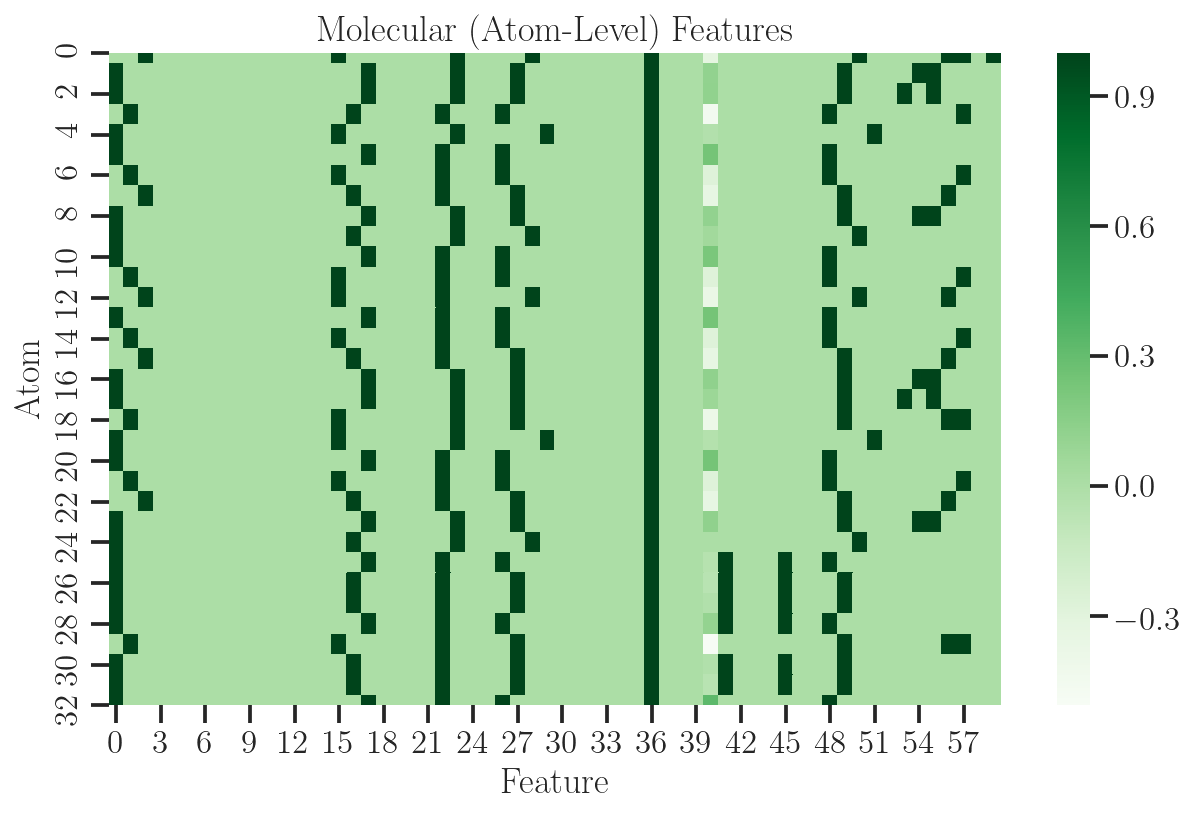

In [48]:
plt.figure(figsize=(10,6))
sns.heatmap(mol_feats, cmap="Greens")
plt.title('Molecular (Atom-Level) Features')
plt.ylabel('Atom')
plt.xlabel('Feature')

Text(0.5, 120.61758015667347, 'Atom')

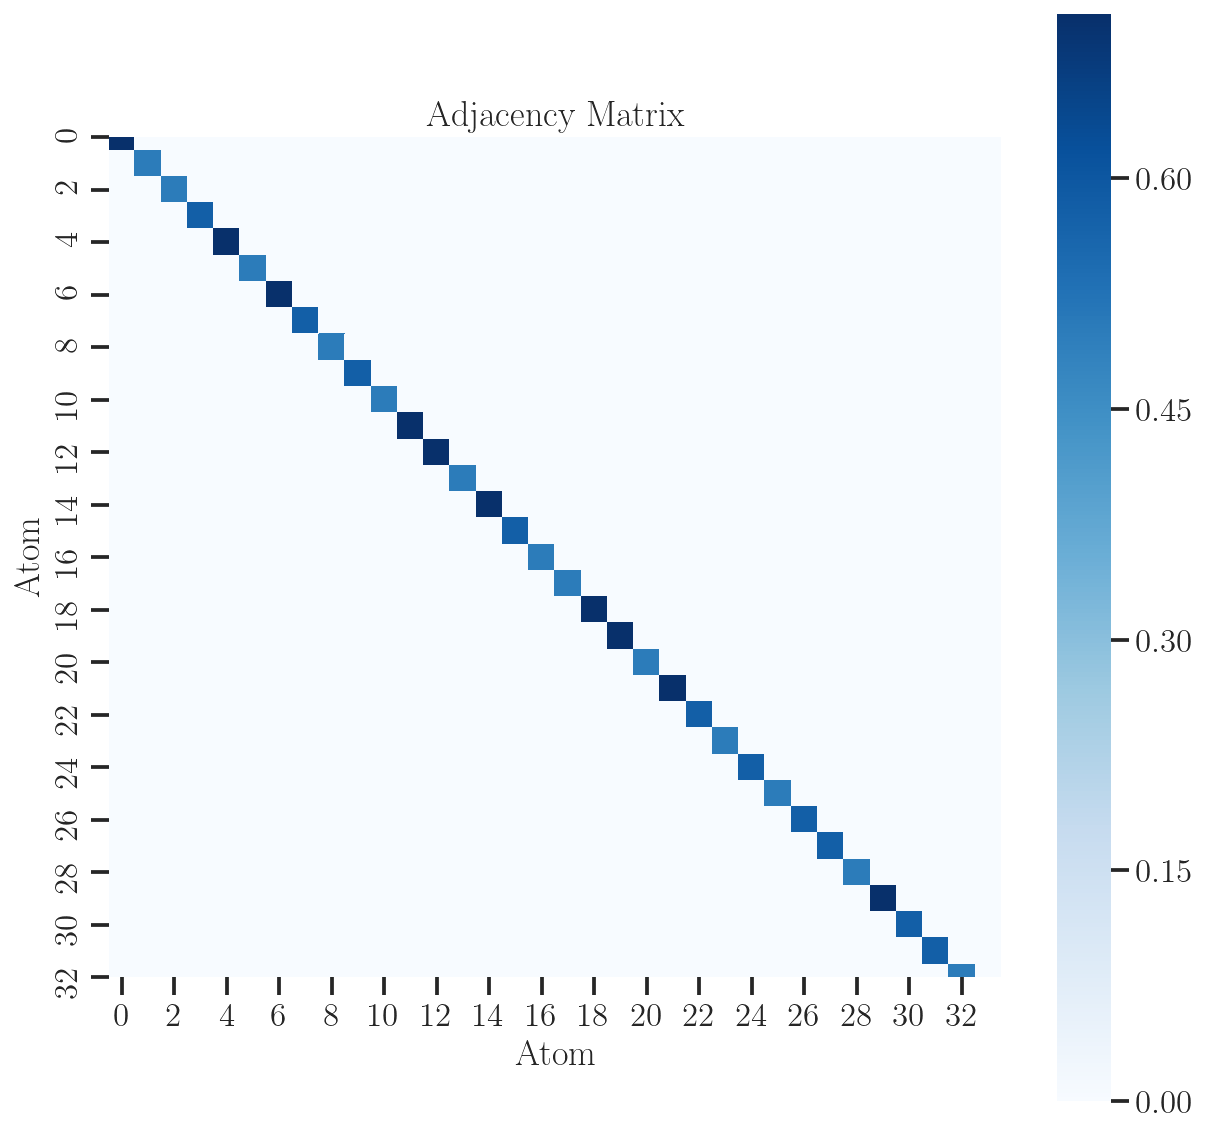

In [55]:
plt.figure(figsize=(10,10))
sns.heatmap(adj_matrix, cmap='Blues', square=True)
plt.title('Adjacency Matrix')
plt.ylabel('Atom')
plt.xlabel('Atom')

In [94]:
xyz_pos = np.reshape(pos_matrix, newshape=(-1, 3))
euclidean_dists = np.linalg.norm(origin-xyz_pos, axis=1) # row-wise euclidean distances
n_atoms = int(np.sqrt(euclidean_dists.shape[0]))
euclidean_pos_matrix = np.reshape(euclidean_dists, newshape=(n_atoms, n_atoms))

Text(0.5, 120.61758015667347, 'Atom')

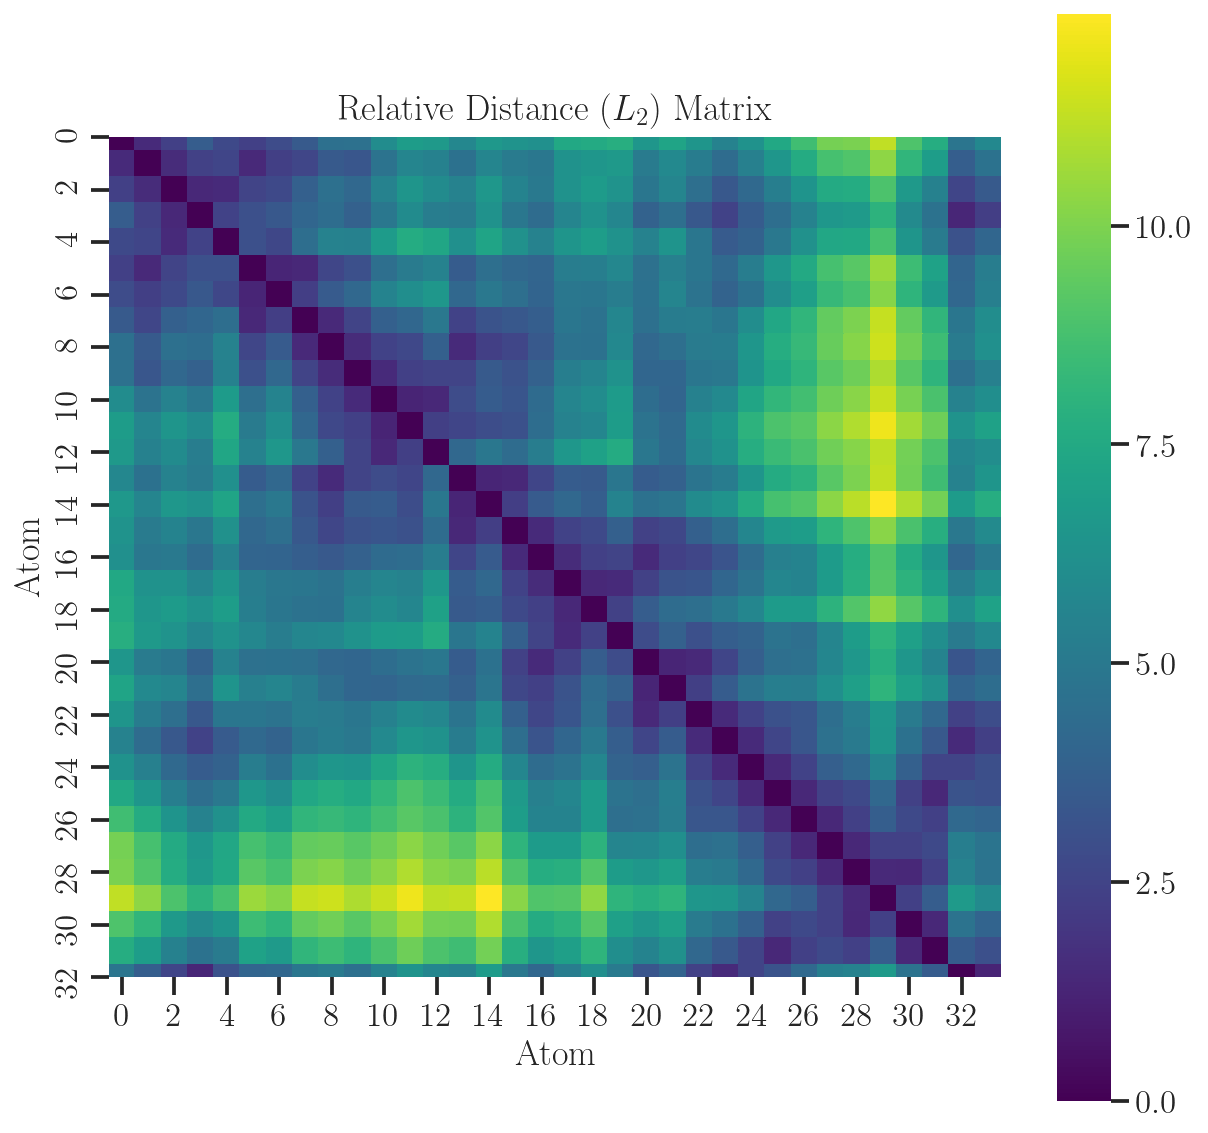

In [104]:
plt.figure(figsize=(10,10))
sns.heatmap(euclidean_pos_matrix, cmap="viridis", square=True)
plt.title('Relative Distance ($L_2$) Matrix')
plt.ylabel('Atom')
plt.xlabel('Atom')

## Distribution of fitness for the given dataset

In [13]:
df = pd.read_csv("../data/raw/vdgv570.csv", sep=',')
df.head(n=10)

,ID,Variants,Fitness
0,133462,TNTY,0.0
1,30784,APPP,0.0
2,130974,TFFM,0.0
3,9290,IDMW,0.0
4,43174,DRNQ,0.0
5,101152,NPYI,0.0
6,45144,EAQQ,0.0
7,104378,PEKW,0.0
8,4899,ECIV,0.0
9,19282,TPIV,0.0


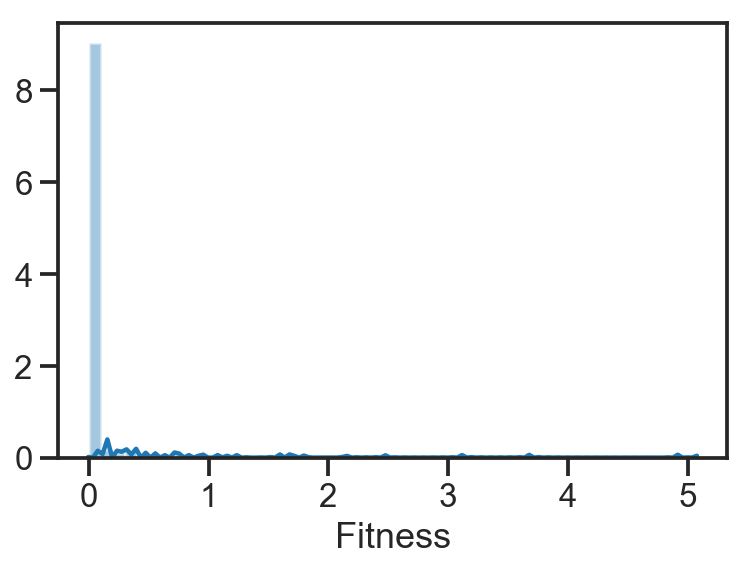

In [22]:
fitness = df['Fitness']
sns.distplot(fitness, bins=50, kde=False)

## Plot fitness map
We want to plot the fitness of the protein for discrete variants of 4 amino acids, which come from a subset of the sequence -> fitness dataset. Convert the sequence to a 2x2 representation so that we can plot it. i.e TNTY -> TN, TY on the x and y axis, respectively. This way we can view both (a) the sparsity of the fitness data we are given and (b) the fitness landscape.   

In [14]:
def generate(n=4):
    """
    Generate all possible combinations of n length amino acid sequence. 
    
    Example:
    --------
    >>> combs = generate(n=2)
    ['AA', 'AR', 'AN', 'AD', ..., 'VV']
    """
    acids = ['A', 'R', 'N', 'D', 'C', 
             'Q', 'E', 'G', 'H', 'I', 
             'L', 'K', 'M', 'F', 'P', 
             'S', 'T', 'W', 'Y', 'V']
    combs = list(itertools.product(acids, repeat=n))
    return np.array(["".join(comb) for comb in combs])

In [15]:
combs = generate(n=2)
fitness_df = pd.DataFrame(0.0, index=combs, columns=combs)
fitness_df.head()

,AA,AR,AN,AD,AC,AQ,AE,AG,AH,AI,...,VL,VK,VM,VF,VP,VS,VT,VW,VY,VV
AA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
for idx, row in df.iterrows():
    variant = row['Variants']
    x,y = variant[:2], variant[2:]
    fitness_df.at[x,y] = row['Fitness']

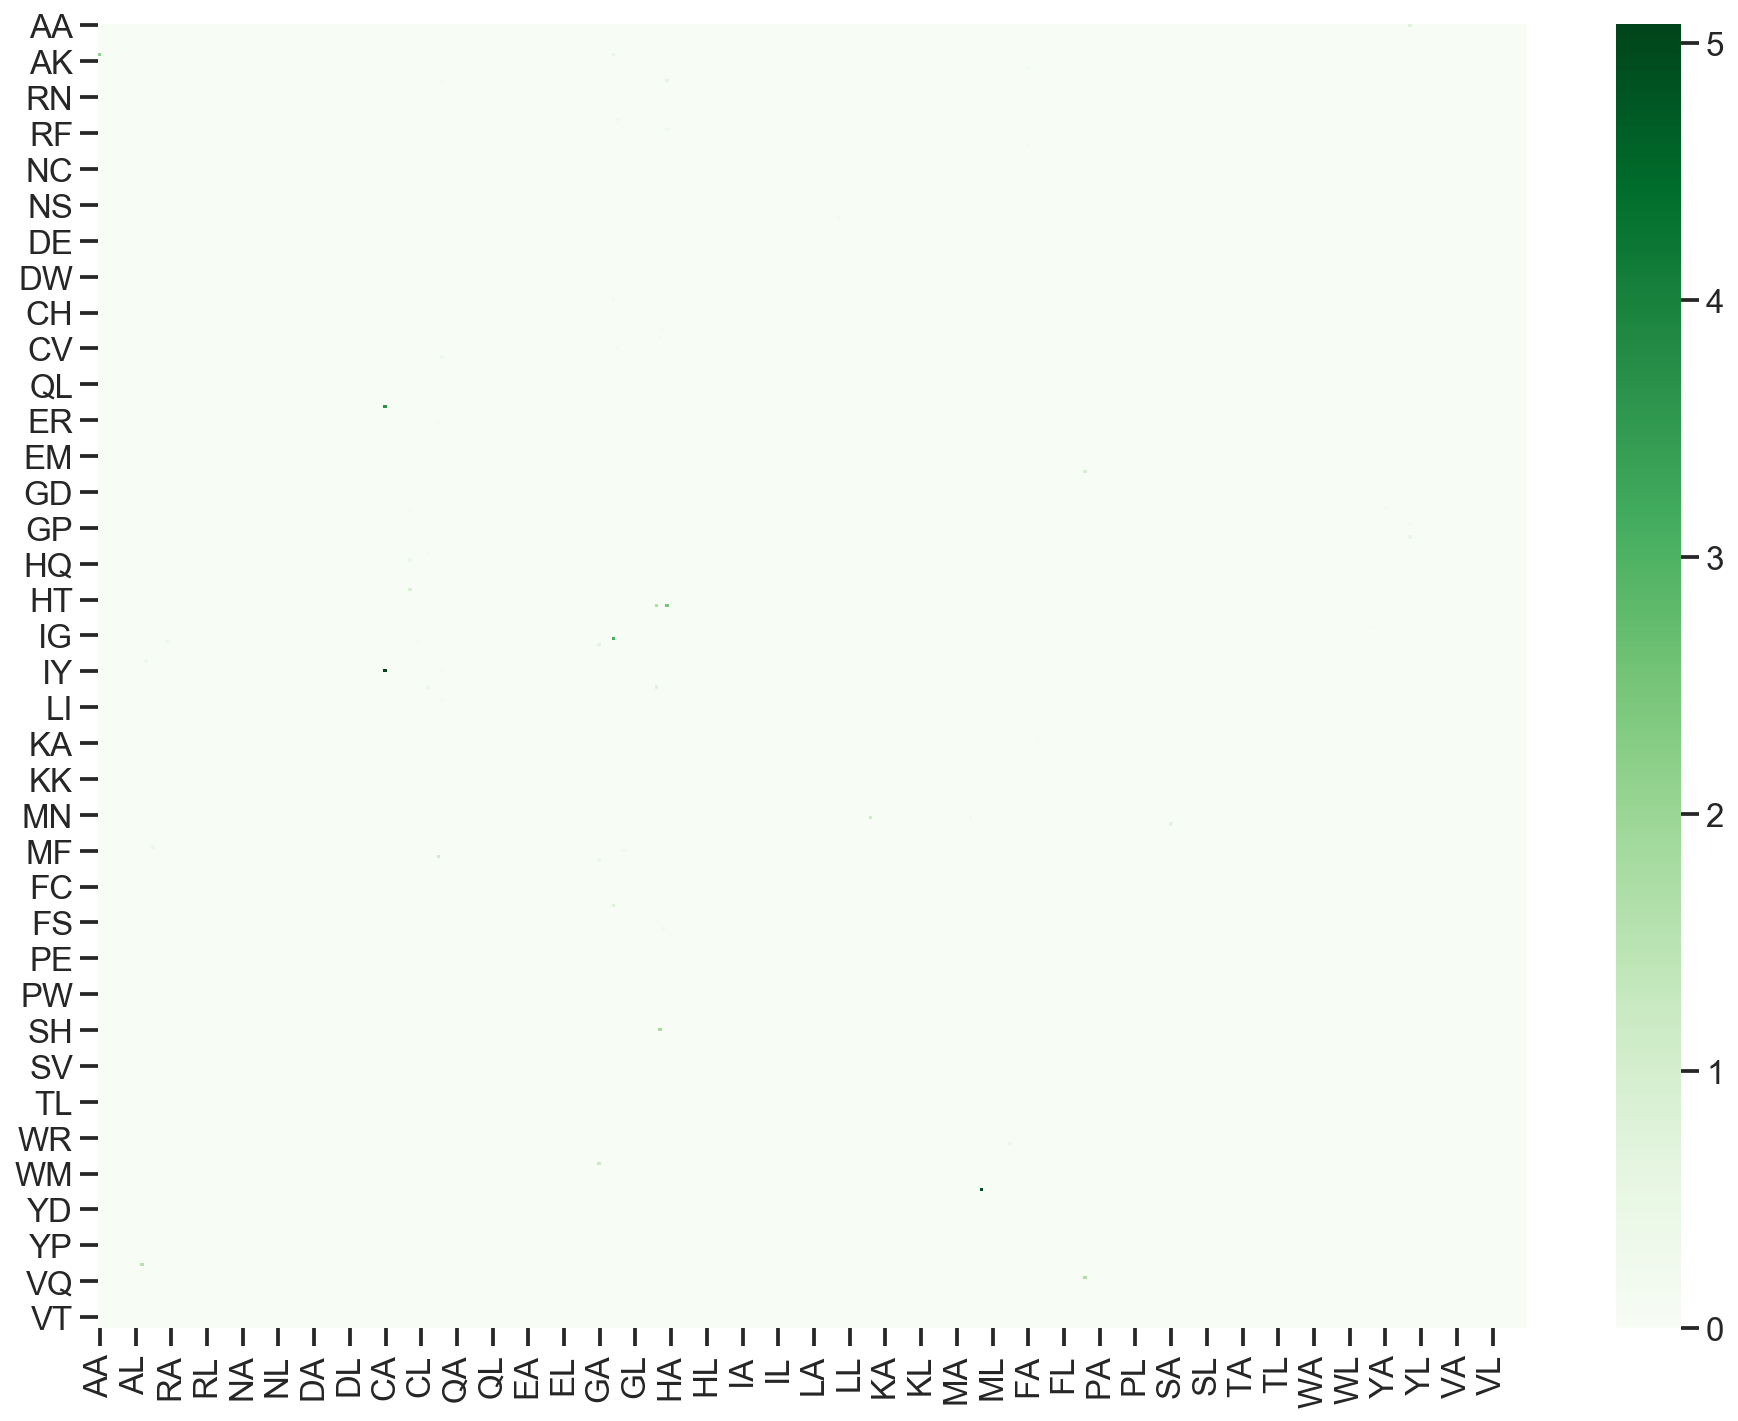

In [17]:
plt.figure(figsize=(16,12))
sns.heatmap(fitness_df, cmap='Greens')

## Determine if there is a correlation between hamming distance (string difference between the parental evolved sequence) and its fitness ratio
Chemically, is the sequences that have a different chemical makeup in different locations affect the fitness of the evolved sequence. For example, non-polar substitutions with another non-polar sequence would allow for similar fitness. 

For the second task, what about the directed evolution. Wouldn't knowing which sequences are those sequences make a difference out prediction accuracy. 

In [18]:
def hamming_dist(s1, s2):
    """
    Determine the number of positions/chars it takes 
    to get from the first string to the second. 
    
    Params:
    -------
    s1: str
    s2: str
        The strings to compare.
    
    Returns:
    --------
    dist: int
        The distance between the strings. 
    """
    assert len(s1) == len(s2)
    return len([True for ch1,ch2 in zip(s1,s2) if ch1 != ch2])

def compute_distance(row):
    return hamming_dist(row['Variants'], 'VDGV')

In [19]:
df['Hamming'] = df.apply(compute_distance, axis=1)
df.head(n=10)

,ID,Variants,Fitness,Hamming
0,133462,TNTY,0.0,4
1,30784,APPP,0.0,4
2,130974,TFFM,0.0,4
3,9290,IDMW,0.0,3
4,43174,DRNQ,0.0,4
5,101152,NPYI,0.0,4
6,45144,EAQQ,0.0,4
7,104378,PEKW,0.0,4
8,4899,ECIV,0.0,3
9,19282,TPIV,0.0,3


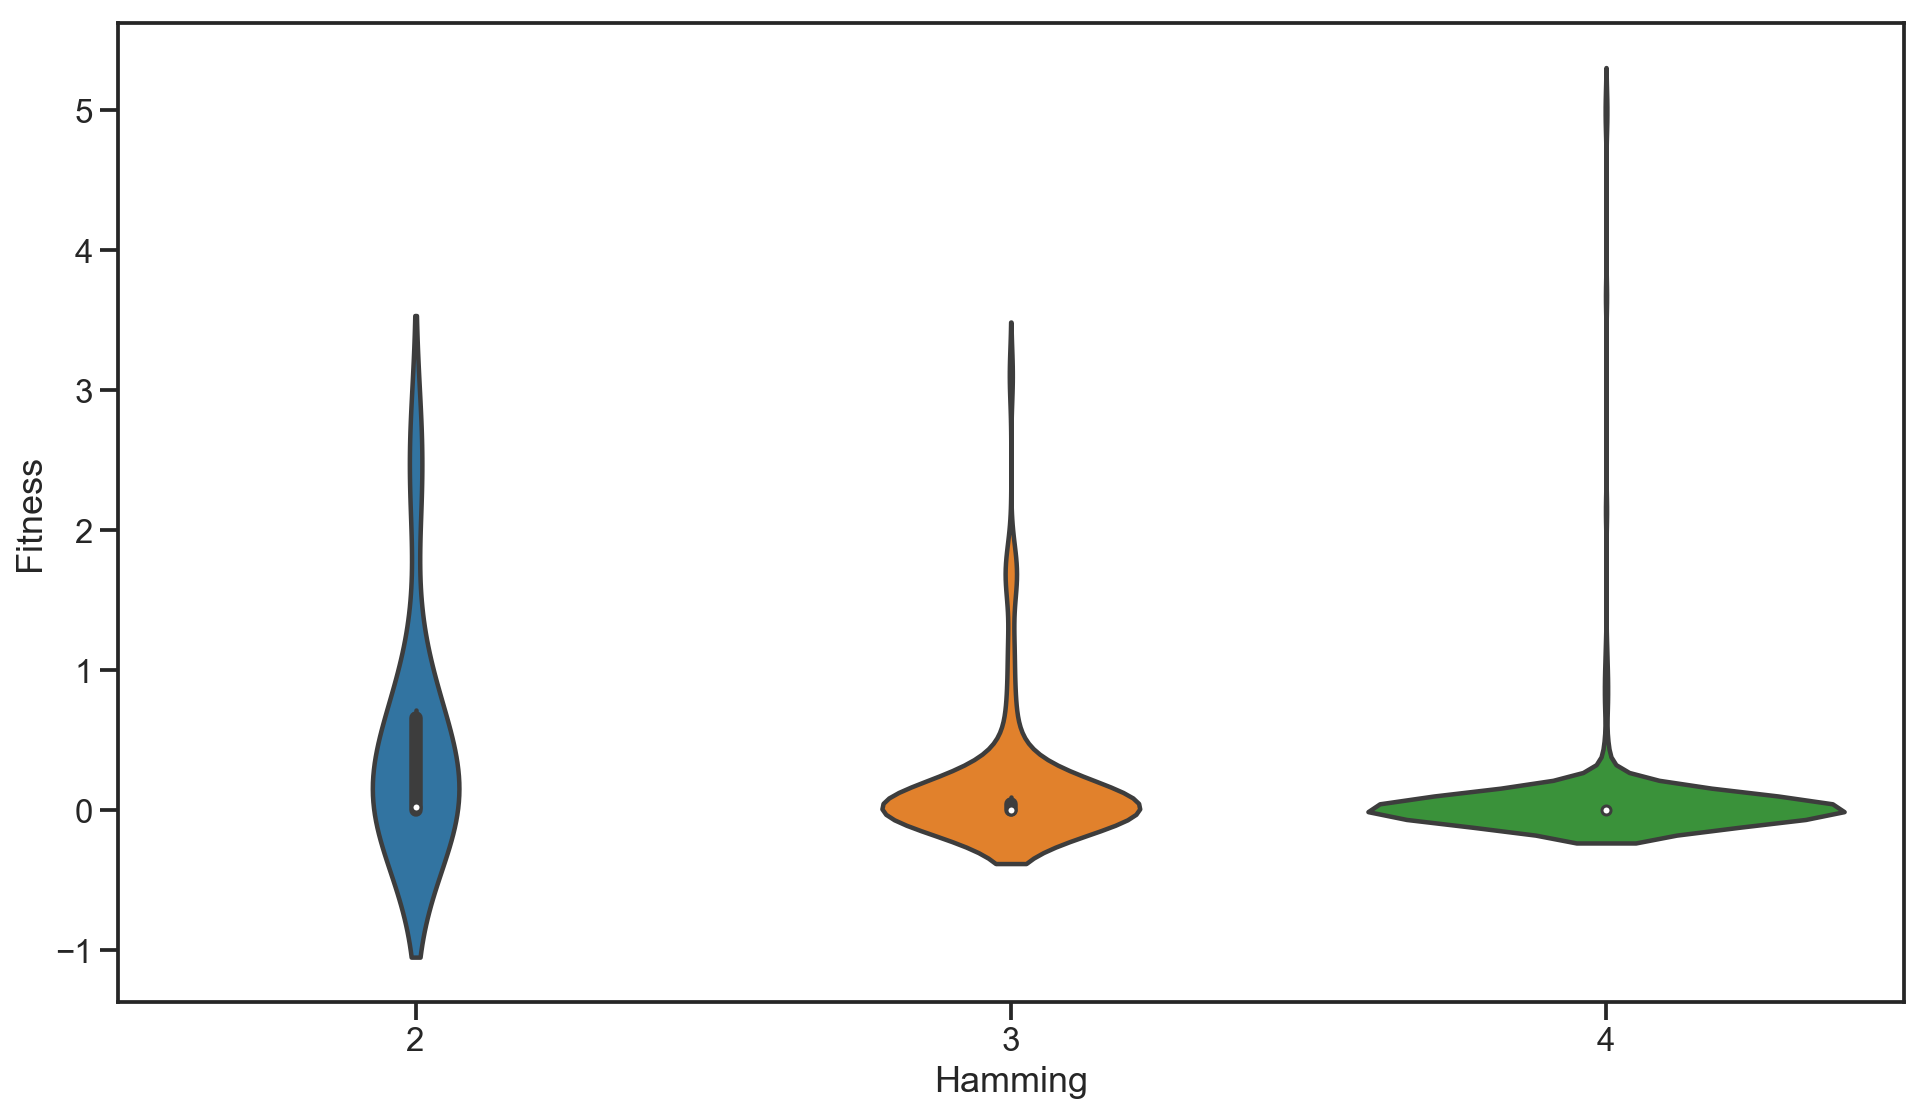

In [20]:
plt.figure(figsize=(16,9))
sns.violinplot(x="Hamming", y="Fitness", data=df)